# Answering Business Questions using SQL

In [2]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [3]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

In [9]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [7]:
def show_tables():
    return run_query('SELECT name, type FROM sqlite_master WHERE type IN ("table","view");')

In [10]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### New artist recommendation

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name      | Genre 
| ---  |    ----   |
| Regal      | Hip-Hop |
| Red Tone   | Punk    |
| Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |

In [16]:
run_query('''
          SELECT t.track_id,g.name,il.quantity FROM genre g
          INNER JOIN track t ON t.genre_id = g.genre_id
          INNER JOIN invoice_line il ON t.track_id = il.track_id
          ''').head()

,track_id,name,quantity
0,1158,Rock,1
1,1159,Rock,1
2,1160,Rock,1
3,1161,Rock,1
4,1162,Rock,1


In [40]:
run_query('''
          SELECT c.country, g.name genre, SUM(quantity) quantity FROM invoice_line il
          INNER JOIN track t ON il.track_id = t.track_id
          INNER JOIN genre g ON t.genre_id = g.genre_id
          INNER JOIN invoice i ON i.invoice_id = il.invoice_id
          INNER JOIN customer c ON i.customer_id = c.customer_id
          WHERE country = 'USA'
          GROUP BY genre
          ORDER BY quantity DESC
          ''')

,country,genre,quantity
0,USA,Rock,561
1,USA,Alternative & Punk,130
2,USA,Metal,124
3,USA,R&B/Soul,53
4,USA,Blues,36
5,USA,Alternative,35
6,USA,Latin,22
7,USA,Pop,22
8,USA,Hip Hop/Rap,20
9,USA,Jazz,14


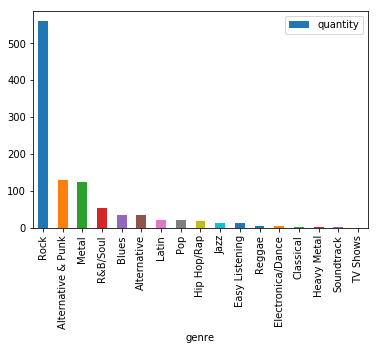

In [42]:
run_query('''
          SELECT c.country, g.name genre, SUM(quantity) quantity FROM invoice_line il
          INNER JOIN track t ON il.track_id = t.track_id
          INNER JOIN genre g ON t.genre_id = g.genre_id
          INNER JOIN invoice i ON i.invoice_id = il.invoice_id
          INNER JOIN customer c ON i.customer_id = c.customer_id
          WHERE country = 'USA'
          GROUP BY genre
          ORDER BY quantity DESC
          ''').plot.bar(x='genre',y='quantity')

Based on the results we recommend the store purchases the albums from **Red Tone (Punk)**, **Slim Jim Bites (Blues)** and **Meteor and the Girls (Pop)**

### New artist recommendation

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [70]:
run_query('''
          SELECT
              e.first_name || ' ' || e.last_name employee_name,
              e.hire_date,
              SUM(i.total) total_sales,
              COUNT(*) num_sales,
              AVG(i.total) avg_sale
          FROM invoice i
          INNER JOIN customer c ON c.customer_id = i.customer_id
          INNER JOIN employee e ON c.support_rep_id = e.employee_id
          GROUP BY employee_name
          ORDER BY total_sales DESC
          ''')

,employee_name,hire_date,total_sales,num_sales,avg_sale
0,Jane Peacock,2017-04-01 00:00:00,1731.51,212,8.167500
1,Margaret Park,2017-05-03 00:00:00,1584.00,214,7.401869
2,Steve Johnson,2017-10-17 00:00:00,1393.92,188,7.414468


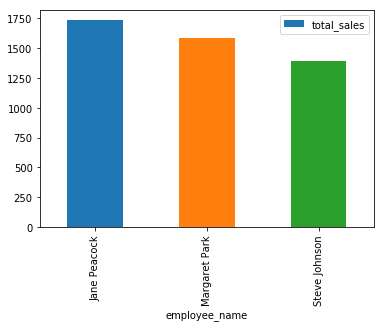

In [71]:
run_query('''
          SELECT
              e.first_name || ' ' || e.last_name employee_name,
              e.hire_date,
              SUM(i.total) total_sales,
              COUNT(*) num_sales,
              AVG(i.total) avg_sale
          FROM invoice i
          INNER JOIN customer c ON c.customer_id = i.customer_id
          INNER JOIN employee e ON c.support_rep_id = e.employee_id
          GROUP BY employee_name
          ORDER BY total_sales DESC
          ''').plot.bar(x='employee_name',y='total_sales')

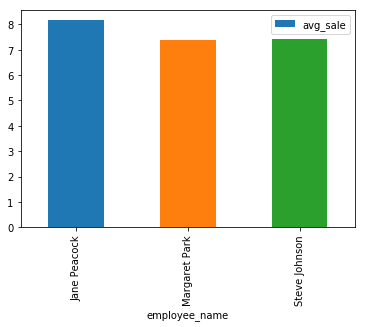

In [72]:
run_query('''
          SELECT
              e.first_name || ' ' || e.last_name employee_name,
              e.hire_date,
              SUM(i.total) total_sales,
              COUNT(*) num_sales,
              AVG(i.total) avg_sale
          FROM invoice i
          INNER JOIN customer c ON c.customer_id = i.customer_id
          INNER JOIN employee e ON c.support_rep_id = e.employee_id
          GROUP BY employee_name
          ORDER BY total_sales DESC
          ''').plot.bar(x='employee_name',y='avg_sale')

We can't take that many conclusions out of these results since the top performer (Jane Peacock) and the bottom performer (Steve Johnson) have also a difference in hiring date.

Comparing the average sale, we can say Jane Peacock is the best performer, although she's the more senior.

### Country statistics
For each country, we want to calculate:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value


In [141]:
run_query('''
          WITH countries_data AS (
              SELECT
                  CASE
                      WHEN COUNT(DISTINCT c.customer_id) = 1 THEN 'Others'
                      ELSE country
                      END AS countries,
                  SUM(i.total) total_sales,
                  COUNT(DISTINCT c.customer_id) num_customers,
                  COUNT(c.customer_id) num_purchases                  
              FROM invoice i
              INNER JOIN customer c ON i.customer_id = c.customer_id
              GROUP BY country
              ORDER BY num_customers DESC
              )
              SELECT
                  countries,
                  SUM(num_customers) num_customers,
                  total_sales,
                  total_sales / num_customers avg_sale_per_customer,
                  total_sales / num_purchases avg_order_value
              FROM countries_data
              GROUP BY countries
              ORDER BY total_sales DESC
          ''')

,countries,num_customers,total_sales,avg_sale_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Others,15,75.24,75.240000,7.524000


In [142]:
countries_table = run_query('''
          WITH countries_data AS (
              SELECT
                  CASE
                      WHEN COUNT(DISTINCT c.customer_id) = 1 THEN 'Others'
                      ELSE country
                      END AS countries,
                  SUM(i.total) total_sales,
                  COUNT(DISTINCT c.customer_id) num_customers,
                  COUNT(c.customer_id) num_purchases                  
              FROM invoice i
              INNER JOIN customer c ON i.customer_id = c.customer_id
              GROUP BY country
              ORDER BY num_customers DESC
              )
              SELECT
                  countries,
                  SUM(num_customers) num_customers,
                  total_sales,
                  total_sales / num_customers avg_sale_per_customer,
                  total_sales / num_purchases avg_order_value
              FROM countries_data
              GROUP BY countries
              ORDER BY total_sales DESC
          ''')

In [145]:
#Exclude 'Others'
countries_table = countries_table[:9]

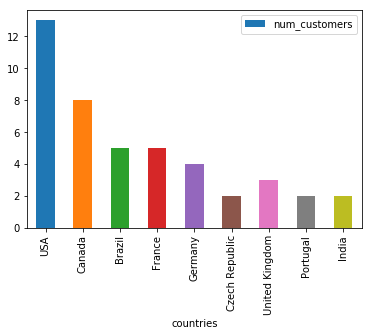

In [148]:
countries_table.plot.bar(x='countries',y='num_customers')

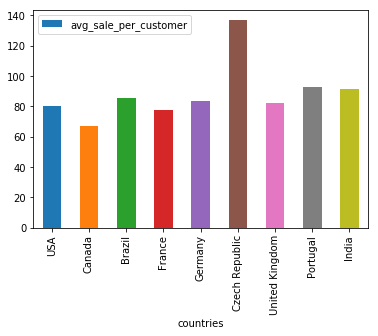

In [149]:
countries_table.plot.bar(x='countries',y='avg_sale_per_customer')

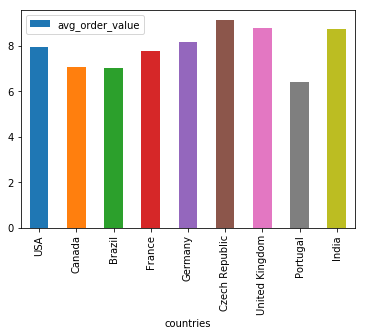

In [150]:
countries_table.plot.bar(x='countries',y='avg_order_value')

Marketing campaigns should be towards:
- **Canada** to improve average sale per customer
- **Portugal** to improve average order value

### Tracks vs Album purchases

In [191]:
run_query(
        '''
        SELECT
            il.invoice_id,
            COUNT(*) tracks_purchased,
            CASE
                WHEN COUNT(DISTINCT t.album_id) = 1 AND COUNT(t.album_id) > 2 THEN 'Album purchase'
                ELSE 'Tracks purchase'
            END as album_or_tracks
        FROM invoice_line il
        INNER JOIN track t ON il.track_id = t.track_id
        INNER JOIN album a ON t.album_id = a.album_id
        GROUP BY invoice_id
        ORDER BY il.invoice_line_id
            ''')['album_or_tracks'].value_counts()

Tracks purchase    481
Album purchase     133
Name: album_or_tracks, dtype: int64

Tracks purchases account for 78% of the revenue, so it is advisable not to disable this type of purchase.